<a href="https://colab.research.google.com/github/KimMinoo/PM2.5-Prediction/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
# test_aws = pd.read_csv('/content/test_aws')
# test_pm = pd.read_csv('/content/test_pm')
# train_aws = pd.read_csv('/content/train_aws')
# train_pm = pd.read_csv('/content/train_pm')

# train_df = pd.merge(test_aws, test_pm)
# test_df = pd.merge(train_aws, train_pm)
train_df = pd.read_csv('/content/공주_mod.csv')
test_df = pd.read_csv('/content/공주_val.csv')

del train_df['일시']
del test_df['일시']
del train_df['강수량(mm)']
del test_df['강수량(mm)']

# del train_df['풍향(deg)']
# del test_df['풍향(deg)']
# del train_df['풍속(m/s)']
# del test_df['풍속(m/s)']

train_df=train_df.interpolate()
test_df=test_df.interpolate()

train_df = train_df.dropna()
test_df = train_df.dropna()

train_size = int(len(train_df)*0.8)
train_set = train_df[0:train_size]  
val_set = train_df[train_size:]
test_set = test_df

# train_set = train_set.transpose()
# val_set = val_set.transpose()
# test_set = test_set.transpose()

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 2
batch = 40

# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용


train_df


,기온(°C),풍향(deg),풍속(m/s),습도(%),PM2.5
0,0.173776,0.201944,0.023018,0.828,0.056
1,0.176935,0.168611,0.030691,0.831,0.060
2,0.180095,0.087222,0.033248,0.784,0.068
3,0.178515,0.087222,0.025575,0.745,0.060
4,0.164297,0.113889,0.020460,0.750,0.068
...,...,...,...,...,...
26275,0.205371,0.413333,0.015345,0.769,0.080
26276,0.200632,0.355833,0.017903,0.791,0.100
26277,0.218009,0.000000,0.010230,0.746,0.100
26278,0.203791,0.432778,0.012788,0.795,0.100


In [ ]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length-72):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length:i+seq_length+72, -1].reshape(-1,1)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# # 데이터셋 생성 함수
# def AWS_build_dataset(time_series, seq_length):
#     dataX = []
#     dataY = []
#     for i in range(0, len(time_series)-seq_length):
#         _x = time_series[i:i+seq_length, :-1]
#         _y = time_series[i+seq_length, :-1]
#         dataX.append(_x)
#         dataY.append(_y)
#     return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
valX, valY = build_dataset(np.array(val_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

trainX_tensor = torch.FloatTensor(trainX).cuda()
trainY_tensor = torch.FloatTensor(trainY).cuda()

valX_tensor = torch.FloatTensor(valX).cuda()
valY_tensor = torch.FloatTensor(valY).cuda()

testX_tensor = torch.FloatTensor(testX).cuda()
testY_tensor = torch.FloatTensor(testY).cuda()

train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset = TensorDataset(valX_tensor, valY_tensor)
test_dataset = TensorDataset(testX_tensor, testY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
train_dataloader = DataLoader(train_dataset,batch_size=batch, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)



In [ ]:
# 설정값
data_dim = 5
hidden_dim = 24
output_dim = 1
learning_rate = 0.01
nb_epochs = 1500

class encoder(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, layers):
        super(encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.15,
                            batch_first=True)
        
    # 예측을 위한 함수
    def forward(self, x):
        x, (hidden_stat, cell_stat) = self.lstm(x)
        return hidden_stat, cell_stat


class decoder(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, layers):
        super(decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.15,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 

    # 예측을 위한 함수
    def forward(self, input, hidden_stat, cell_stat):
        x, (hidden_stat, cell_stat) = self.lstm(input, (hidden_stat, cell_stat))
        prediction = self.fc(x)
        
        return prediction, hidden_stat, cell_stat        

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        # encoder와 decoder의 hid_dim이 일치하지 않는 경우 에러메세지
        assert encoder.hidden_dim == decoder.hidden_dim, \
            'Hidden dimensions of encoder decoder must be equal'
        # encoder와 decoder의 hid_dim이 일치하지 않는 경우 에러메세지
        assert encoder.layers == decoder.layers, \
            'Encoder and decoder must have equal number of layers'

    def forward(self, encoder_input, decoder_input):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        batch_size = 40
        decoder_len = 72
        decoder_output_dim = 1
         

        # decoder의 output을 저장하기 위한 tensor
        outputs = torch.empty(40,0,1).cuda()

        # initial hidden state
        hidden, cell = self.encoder(encoder_input)

        # 첫 번째 입력값 <sos> 토큰
        # input = encoder_input[:,-1,[-1]].unsqueeze(1).to(self.device)
        input = torch.zeros(40,1,1).to(self.device)
        for i in range(0,decoder_len): # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden, cell = self.decoder(input, hidden, cell)

            # prediction 저장
            outputs = torch.cat([outputs,output],dim=1)

            # teacher forcing을 사용할지, 말지 결정
            if self.teacher_forcing_ratio != 0:
                teacher_force = random.random() < self.teacher_forcing_ratio
                input = decoder_input[:,i,[-1]].unsqueeze(1) if teacher_force else output
            elif self.teacher_forcing_ratio == 0:
                input = output

        return outputs

In [ ]:
import time

def train():
    start_time = time.time()
    model.train()

    total = 0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        x, y = batch
            
        output = model(x,y)
        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
            
        total += 1
        running_loss += loss.item()

    return running_loss/total

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.eval()

    total = 0
    running_loss = 0.0

    for i, batch in enumerate(val_dataloader):
        x, y = batch

        with torch.no_grad(): 
          output = model(x,y)
          loss = criterion(output, y)
            
        total += 1
        running_loss += loss.item()

    return running_loss/total

def test():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.eval()

    total = 0
    running_loss = 0.0

    for i, batch in enumerate(test_dataloader):
        x, y = batch

        with torch.no_grad(): 
          output = model(x,y)
          loss = criterion(output, y)
            
        total += 1
        running_loss += loss.item()

    return running_loss/total

In [ ]:
import time

# def adjust_learning_rate(optimizer, epoch):
#   lr = learning_rate
#   if epoch % 10 == 0:
#     lr /= 5
#   for param_group in optimizer.param_groups:
#     param_group['lr'] = lr

In [ ]:
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = encoder(data_dim, hidden_dim, 1).cuda()
dec = decoder(1, hidden_dim, 1).cuda()
model = Seq2Seq(enc, dec, device, 0.5).to(device)
model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 25
best_epoch = 0
verbose = 1
patience = 25

history = []

for epoch in range(num_epochs):
    # adjust_learning_rate(optimizer, epoch)
    train_loss = train()
    val_loss = validate()
    history.append((train_loss, val_loss))

    if epoch % verbose == 0:
        print('train loss:',train_loss,'\tval_loss:',val_loss)
            
        # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
        if history[epoch][0] < history[epoch-10][0]:
                print('\n Early Stopping')
                break

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

test_loss = test()
print(f"Test loss: {test_loss: .8f}")

[Epoch: 1 - Training]
train loss: 0.0014804369963867586 	val_loss: 0.00048718493995383063
[Epoch: 2 - Training]
train loss: 0.0008502115824270502 	val_loss: 0.0004783933080372747
[Epoch: 3 - Training]
train loss: 0.0009014421499006621 	val_loss: 0.0004971116074113186
[Epoch: 4 - Training]
train loss: 0.0008486005235316471 	val_loss: 0.0008174624928460969
[Epoch: 5 - Training]
train loss: 0.000815863438437196 	val_loss: 0.0004564265142079414
[Epoch: 6 - Training]
train loss: 0.0008416183819405799 	val_loss: 0.0004634899915806956
[Epoch: 7 - Training]
train loss: 0.0008438375992629229 	val_loss: 0.0005836750042785858
[Epoch: 8 - Training]
train loss: 0.0008574233227453941 	val_loss: 0.0005186455722044533
[Epoch: 9 - Training]
train loss: 0.0008225354550087585 	val_loss: 0.00048042610306279235
[Epoch: 10 - Training]
train loss: 0.0008070514461490367 	val_loss: 0.0004936539855209908
[Epoch: 11 - Training]
train loss: 0.0008169950734949483 	val_loss: 0.0005364052872597637
[Epoch: 12 - Train

KeyboardInterrupt: ignored

In [ ]:
!cp /content/last_checkpoint_epoch_1500.pth /content/drive/MyDrive/ai_study/pm2.5_prediction.pth

cp: cannot create regular file '/content/drive/MyDrive/ai_study/pm2.5_prediction.pth': No such file or directory


MAE SCORE :  0.20209086


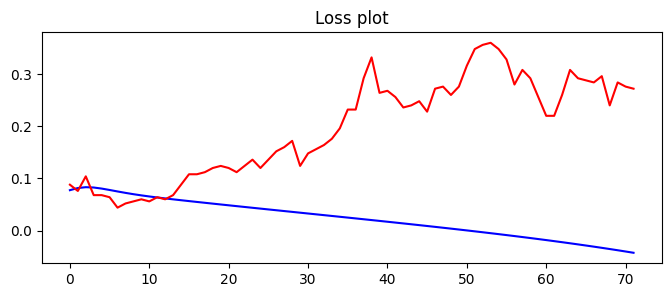

In [ ]:
model2 = Seq2Seq(enc, dec, device, 0).to(device)
model2.load_state_dict(torch.load("/content/last_checkpoint_epoch_5.pth"))
test = iter(test_dataloader)
original_input, original_output = next(test)
pred_output = model2(original_input, original_output)

# prediction = scaler_y.inverse_transform(np.array(pred_output.cpu().detach()))
# original = scaler_y.inverse_transform(np.array(original_output.cpu().detach()))

prediction= np.array(pred_output.cpu().detach())
original = np.array(original_output.cpu().detach())


def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(prediction, original))

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(prediction[5])), prediction[5], 'b', label = 'pred')
plt.plot(np.arange(len(original[5])), original[5], 'r', label = 'original')
plt.title("Loss plot")
plt.show()







